In [24]:
#Cell 1: Setup and Path Definition (Variables: HOME_DIR, FILE_PATH, SEED_COORDINATE, SLICE_INDEX)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

# Optional: Add the line below to display the plots inline in the notebook
# %matplotlib inline 

# --- PATH DEFINITION ---
# Path.home() resolves to /Users/petertruong/
HOME_DIR = Path.home()
SLICE_INDEX = 50 # Choose a central slice for visualization

# **CRITICAL: EDIT THIS PATH TO MATCH YOUR FOLDER NAMES EXACTLY**
# The final part of the path must be the folder *containing* the 255 DICOM files.
# The folder names below are from your last successful attempt, but you must check
# the folder name 08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614 in your Finder
# to correct any minor spelling or spacing errors.

FILE_PATH_OBJECT = (
    HOME_DIR / 'Downloads' / 'CSC 621 - Biomedical Imaging & Analysis' / 
    'manifest-1764727503594' / 'MIDRC-RICORD-1A' / 'MIDRC-RICORD-1A-419639-000082' / 
    '08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614' / 
    '2.000000-ROUTINE CHEST NON-CON-97100' # The folder with the .dcm files
)

FILE_PATH = str(FILE_PATH_OBJECT) 

print(f"Constructed File Path (to be tested in next cell):\n{FILE_PATH}")

Constructed File Path (to be tested in next cell):
/Users/petertruong/Downloads/CSC 621 - Biomedical Imaging & Analysis/manifest-1764727503594/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100


Checking for DICOM files in: /Users/petertruong/Downloads/CSC 621 - Biomedical Imaging & Analysis/manifest-1764727503594/MIDRC-RICORD-1A/MIDRC-RICORD-1A-419639-000082/08-02-2002-NA-CT CHEST WITHOUT CONTRAST-04614/2.000000-ROUTINE CHEST NON-CON-97100
Found: 255 files
First 5 files found:
1-255.dcm
1-254.dcm
1-253.dcm
1-252.dcm
1-251.dcm

3D Image successfully loaded. Size: (512, 512, 255)
Extracted 2D Slice 50. Size: (512, 512)


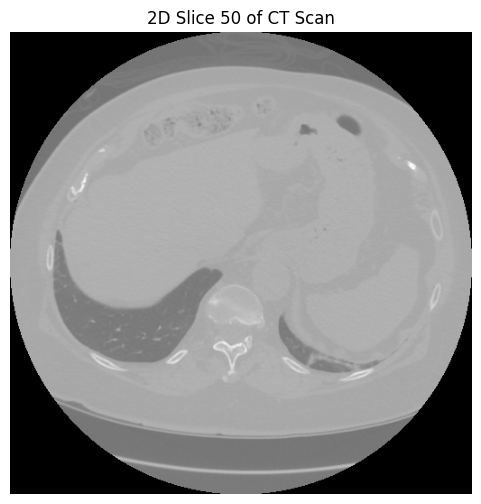

In [25]:
# Cell 2: Data Loading and Diagnosis (Output: input_image_3d, File list, Raw 2D image)
# This cell uses the FILE_PATH and SLICE_INDEX variables defined in Cell 1

print(f"Checking for DICOM files in: {FILE_PATH}")

try:
    # 1. DIAGNOSE: Use ImageSeriesReader to explicitly find the DICOM files
    series_reader = sitk.ImageSeriesReader()
    
    # Get the list of file names found in the directory
    dicom_names = series_reader.GetGDCMSeriesFileNames(FILE_PATH)
    
    # Check if files were found (This is the output your group mate got)
    if not dicom_names:
        raise RuntimeError("No DICOM files (.dcm) found in the specified directory. The path is likely correct, but the folder is empty or contains non-DICOM files.")
        
    print(f"Found: {len(dicom_names)} files")
    print("First 5 files found:")
    for name in dicom_names[:5]:
        # Print only the filename, not the full path, for clean output
        print(Path(name).name)
    
    # 2. LOAD: Load the 3D volume
    series_reader.SetFileNames(dicom_names)
    input_image_3d = series_reader.Execute() 
    print(f"\n3D Image successfully loaded. Size: {input_image_3d.GetSize()}")
    
    # 3. VISUALIZE: Extract and Display the 2D Slice
    size = list(input_image_3d.GetSize())
    # Set the depth dimension (Z) to 0 to extract a 2D slice
    size[2] = 0 
    # Set the starting index for the slice extraction (X=0, Y=0, Z=SLICE_INDEX)
    index = [0, 0, SLICE_INDEX] 

    input_image_2d = sitk.Extract(input_image_3d, size, index)
    
    print(f"Extracted 2D Slice {SLICE_INDEX}. Size: {input_image_2d.GetSize()}")

    # Display the 2D slice 
    plt.figure(figsize=(6, 6))
    plt.imshow(sitk.GetArrayFromImage(input_image_2d), cmap='gray')
    plt.title(f"2D Slice {SLICE_INDEX} of CT Scan")
    plt.axis('off')
    plt.show()
    
except RuntimeError as e:
    print(f"\nError loading image: {e}")
    print("\n🚨 Please return to Cell 1 and re-verify the full path, focusing on the study folder name.")

In [34]:
# Cell 3: B3 Region Growing (Output: segmentation)
# This cell performs the B3 Segmentation (2D Region Growing)

# --- Extract 2D Slice ---
# input_image_3d is available from Cell 2
image_size = input_image_3d.GetSize()

# Define 2D slice parameters: [X_size, Y_size, 0]
size_2d = [image_size[0], image_size[1], 0] 
index_2d = [0, 0, SLICE_INDEX] 

# Extract the 2D slice to work on
input_image_2d = sitk.Extract(input_image_3d, size_2d, index_2d)
print(f"Extracted 2D Slice {SLICE_INDEX} for segmentation. Size: {input_image_2d.GetSize()}")

# --- Prepare 2D Seed ---
# Use only the X and Y components of the 3D seed from Cell 1
SEED_COORDINATE_2D = (SEED_COORDINATE[0], SEED_COORDINATE[1]) 

print(f"Starting 2D Region Growing Segmentation using seed: {SEED_COORDINATE_2D}")

# 1. Image Smoothing (Applied to the 2D slice)
smoothed_image_2d = sitk.CurvatureFlow(image1=input_image_2d, timeStep=0.125, numberOfIterations=5)

# 2. Confidence Connected Filter (2D Region Growing)
# Apply to the 2D slice with the 2D seed point
segmentation_2d = sitk.ConfidenceConnected(image1=smoothed_image_2d, seedList=[SEED_COORDINATE_2D], numberOfIterations=1, multiplier=3.0,       
 replaceValue=1)       # Label the segmented region with the value 1

print("2D Segmentation complete. The result is a 2D label image stored in 'segmentation_2d'.")

Extracted 2D Slice 50 for segmentation. Size: (512, 512)
Starting 2D Region Growing Segmentation using seed: (100, 100)
2D Segmentation complete. The result is a 2D label image stored in 'segmentation_2d'.


Starting post-processing (Binary Morphological Closing)...
Post-processing complete.


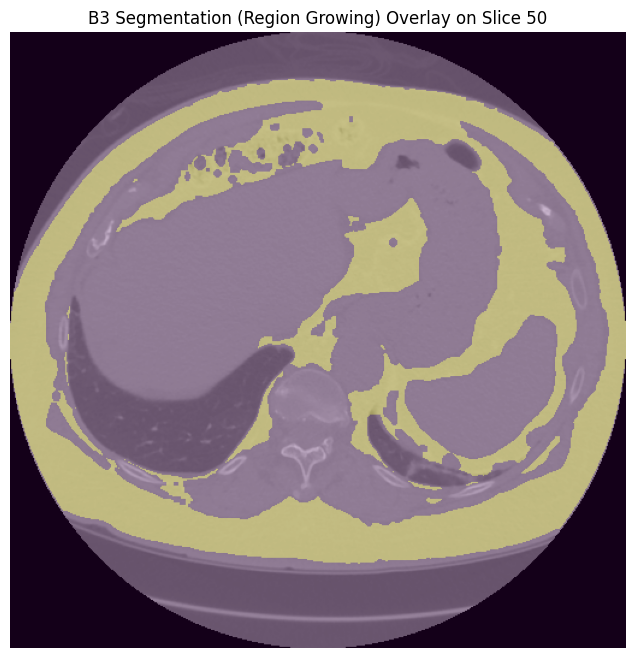


Quantification Result: Segmented Volume = 9,209,919.75 cubic millimeters (mm³)


In [33]:
# Cell 4: Post-Processing, Visualization, and Quantification (Output: clean_segmentation, Overlay image, Volume result)
# This cell assumes input_image_3d (raw data), segmentation (from ConfidenceConnected), 
# SLICE_INDEX, size, and index (slice coordinates) were successfully created in Cells 2 and 3.

# 1. Post-Processing: Fill holes and smooth boundaries (Binary Morphological Closing)
print("Starting post-processing (Binary Morphological Closing)...")
vectorRadius = [3] * 3  # 3x3x3 pixel radius for the closing operation
kernel = sitk.sitkBall 

# Apply closing to the 'segmentation' output from Cell 3
clean_segmentation = sitk.BinaryMorphologicalClosing(segmentation, vectorRadius, kernel)
print("Post-processing complete.")

# --- Preparation for Visualization ---
# We need to correctly define 'size' and 'index' again, using the loaded image.
# This prevents errors if Cell 3 was skipped or edited incorrectly.

# Get the size of the 3D volume
image_size = input_image_3d.GetSize()

# Define 2D slice parameters: 
# size = [X_size, Y_size, 0] 
# index = [0, 0, SLICE_INDEX] 
size = [image_size[0], image_size[1], 0]
index = [0, 0, SLICE_INDEX]

# Extract the raw 2D image slice from the loaded 3D data (input_image_3d)
input_image_2d_raw = sitk.Extract(input_image_3d, size, index) 


# 2. Extract and Visualize the Segmented Slice
seg_2d = sitk.Extract(clean_segmentation, size, index)

# Convert the segmentation mask to a NumPy array for visualization
seg_array = sitk.GetArrayFromImage(seg_2d)

# Create an overlay image: show the CT scan but highlight the segmented area
plt.figure(figsize=(8, 8))
plt.imshow(sitk.GetArrayFromImage(input_image_2d_raw), cmap='gray')
plt.imshow(seg_array, cmap='viridis', alpha=0.3)  # Overlay the segmentation with transparency
plt.title(f"B3 Segmentation (Region Growing) Overlay on Slice {SLICE_INDEX}")
plt.axis('off')
plt.show()

# 3. Basic Quantification Example (Volume)
label_stats = sitk.LabelShapeStatisticsImageFilter()
label_stats.Execute(clean_segmentation)

# Get the volume (in physical units) of the segmented region (label 1)
if label_stats.HasLabel(1):
    volume_cc = label_stats.GetPhysicalSize(1)
    print(f"\nQuantification Result: Segmented Volume = {volume_cc:,.2f} cubic millimeters (mm³)")
else:
    print("\nQuantification Failed: No region with label 1 found. Check your seed point and segmentation parameters in Cell 3.")